# Padded 1D Column Max Signals

Processes cluster data to create standardized 1D signals from column maxes. Pads variable-length cluster projections to a fixed 240-wire length based on their spatial position in the detector.

**Purpose:** Creates uniform input data for machine learning models from variable-sized particle clusters.

Uses data created in **clusters_data.ipynb**



In [22]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [23]:
# Threshold = 15, all connected regions. 
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl")
protonsdf = pd.read_pickle('/Users/user/data/research/proton-deuteron/csv/protonclusters.pkl')
deuteronsdf = pd.read_pickle('/Users/user/data/research/proton-deuteron/csv/deuteronclusters.pkl')

# Cleaning

- length over 10 wires.

In [24]:
print(allclusters.shape)
allclusters = allclusters[allclusters['column_maxes'].map(len) > 15].reset_index(drop=True); print(allclusters.shape)

(438575, 27)
(64032, 27)


In [25]:
allclusters.describe()

,event_idx,run,subrun,event,event_index,cluster_idx,area,max_intensity,min_intensity,mean_intensity,...,centroid_x,centroid_y,bbox_min_row,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness
count,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,...,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000
mean,3577.105229,9155.966033,181.327149,15776.253514,0.206287,12.597420,4165.906781,266.628295,16.000016,64.068248,...,95.777432,1360.838896,49.285342,1244.398316,142.420290,1488.041261,243.642944,93.134948,3.616466,0.239019
std,2068.514591,436.020473,132.915193,11921.915423,0.477740,32.242795,5230.251161,196.521940,0.003952,30.094606,...,50.007122,744.891517,50.611751,758.176836,67.427226,742.371500,207.771899,65.367028,3.601370,0.135304
min,0.000000,8557.000000,1.000000,11.000000,0.000000,0.000000,24.000000,20.000000,16.000000,16.883212,...,3.597895,1.048780,0.000000,0.000000,16.000000,4.000000,3.000000,16.000000,0.147826,0.016106
25%,1777.000000,8680.000000,67.000000,5734.750000,0.000000,0.000000,1306.000000,124.000000,16.000000,39.429672,...,51.752071,873.963191,19.000000,740.000000,77.000000,1024.000000,117.000000,36.000000,1.543590,0.134840
50%,3554.000000,9451.000000,155.000000,13271.000000,0.000000,2.000000,2684.000000,225.000000,16.000000,56.502722,...,91.367018,1210.332662,28.000000,1113.000000,141.000000,1328.000000,190.000000,71.000000,2.687500,0.210174
75%,5360.000000,9509.000000,278.000000,23423.000000,0.000000,10.000000,4975.000000,354.000000,16.000000,81.949376,...,128.317181,1771.515065,52.000000,1664.000000,210.000000,1904.000000,302.000000,155.000000,4.465615,0.318691
max,7635.000000,9788.000000,624.000000,52920.000000,5.000000,507.000000,184515.000000,2354.000000,17.000000,312.279639,...,232.466587,3070.625000,224.000000,3069.000000,240.000000,3072.000000,3072.000000,240.000000,101.062500,0.893832


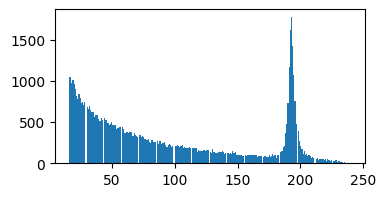

In [26]:
plt.figure(figsize=(4,2)); plt.hist(allclusters['column_maxes'].apply(len), bins=240); plt.show()

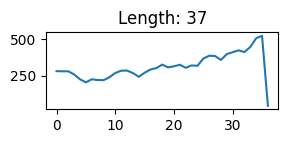

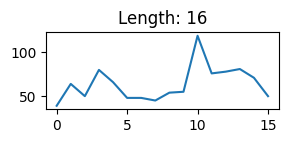

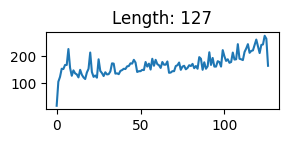

In [27]:
sample = allclusters['column_maxes'].sample(3)

for i, sample in enumerate(sample):
    plt.figure(figsize=(3,1)); plt.plot(sample); plt.title(f"Length: {len(sample)}") 

In [28]:
# TODO: could a simple cut on how much ADC changes work.

# Padding function for 'column_maxes'

In [29]:
def padding(column_maxes, min, max, target=240):
    
    signal = np.array(column_maxes); length = len(signal)
    zeros = np.zeros(target)
    span = max - min + 1
    
    if length != span:
        if abs(length - span) > 2:
            print(f"Length {length} != Span {span}")
    
    start = min
    end = min + length

    zeros[start:end] = signal[0:length]
    
    padded = zeros

    return padded

In [30]:
data = [] # all data

for idx, row in allclusters.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    data.append(padded_signal)

data = np.array(data)

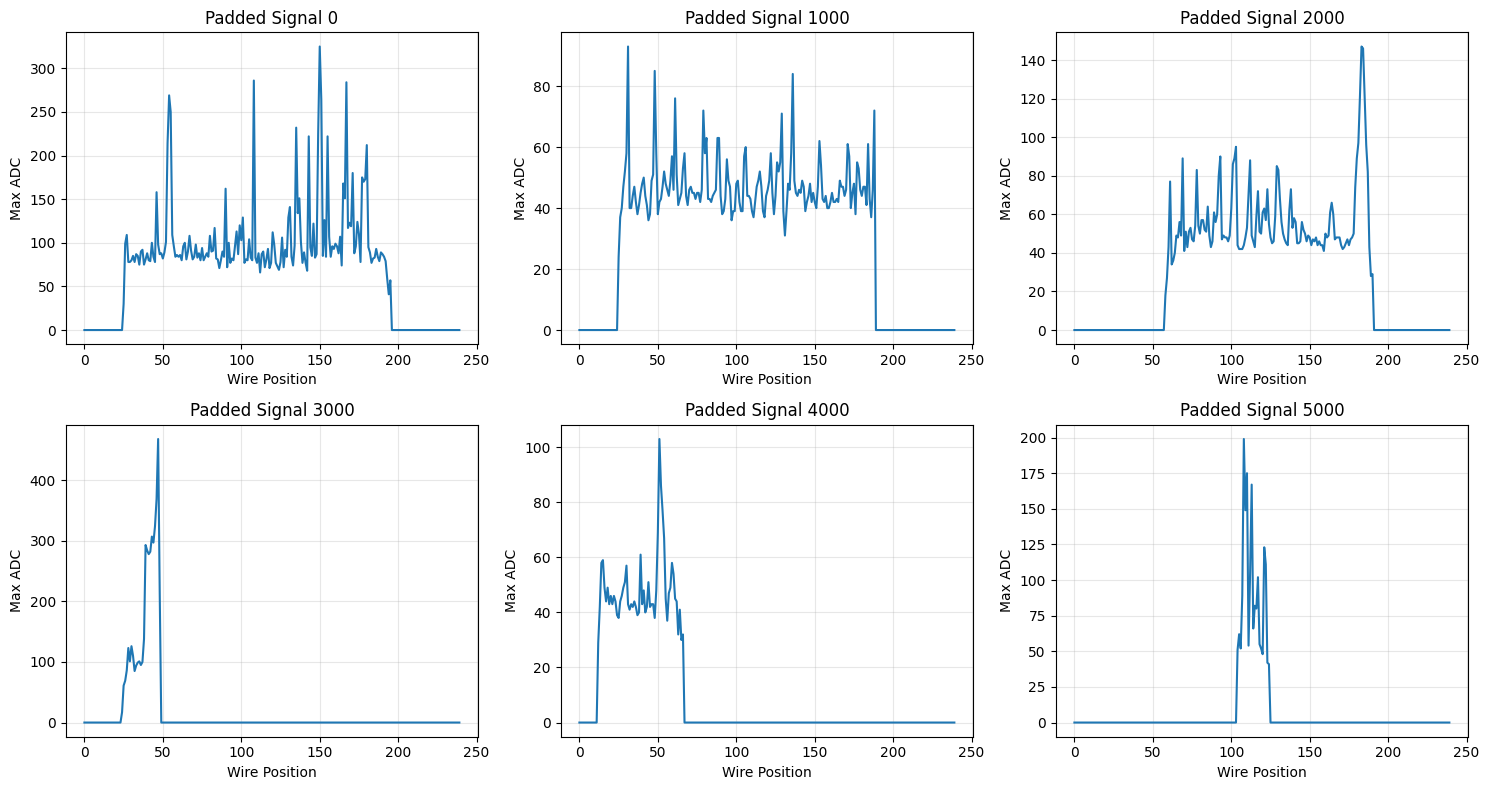

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    signal = data[i * 1000]
    ax.plot(signal)
    ax.set_title(f'Padded Signal {i * 1000}')
    ax.set_xlabel('Wire Position')
    ax.set_ylabel('Max ADC')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
data

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [60., 91., 85., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [33]:
# np.save('padded_max_adc_columns.npy', data)

In [34]:
print(protonsdf.shape); protonsdf = protonsdf[protonsdf['column_maxes'].map(len) > 10].reset_index(drop=True); print(protonsdf.shape)
print(deuteronsdf.shape); deuteronsdf = deuteronsdf[deuteronsdf['column_maxes'].map(len) > 10].reset_index(drop=True); print(deuteronsdf.shape)

(83696, 27)
(16097, 27)
(354879, 27)
(54825, 27)


In [35]:
# protons only

protons = [] # all data

for idx, row in protonsdf.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    protons.append(padded_signal)

protons = np.array(protons)

# np.save('/Users/user/data/research/proton-deuteron/csv/padded_protons.npy', protons)

In [36]:
# deuterons only

deuterons = [] # all data

for idx, row in deuteronsdf.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    deuterons.append(padded_signal)

deuterons = np.array(deuterons)

# np.save('/Users/user/data/research/proton-deuteron/csv/padded_deuterons.npy', deuterons)

Smoothing data for better clustering?

In [37]:
allclusters

,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness,image_intensity,matrix_transformed,column_maxes
0,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,9047.0,...,154,196,944,790,171,4.619883,0.066970,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0...","[30.0, 99.0, 109.0, 78.0, 78.0, 80.0, 85.0, 78..."
1,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,induction,0,4030.0,...,156,169,873,717,148,4.844595,0.037977,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[17.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[20.0, 78.0, 66.0, 55.0, 47.0, 43.0, 47.0, 48...."
2,1,8682,479,43081,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,2346.0,...,553,47,699,146,47,3.106383,0.341883,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 16.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0...","[60.0, 91.0, 85.0, 87.0, 98.0, 94.0, 106.0, 88..."
3,1,8682,479,43081,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,1,11874.0,...,221,215,499,278,194,1.432990,0.220166,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[36.0, 78.0, 68.0, 66.0, 69.0, 62.0, 74.0, 79...."
4,1,8682,479,43081,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,2,10122.0,...,1561,220,1825,264,193,1.367876,0.198658,"[[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0...","[[-0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0....","[43.0, 53.0, 77.0, 133.0, 66.0, 70.0, 72.0, 71..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64027,7633,9788,305,26707,/Users/user/data/research/proton-deuteron/rawp...,0,proton,induction,0,534.0,...,870,33,962,92,20,4.600000,0.290217,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[19.0, 60.0, 70.0, 51.0, 52.0, 54.0, 52.0, 52...."
64028,7634,9788,308,26943,/Users/user/data/research/proton-deuteron/rawp...,0,proton,collection,0,2692.0,...,906,71,1052,146,45,3.244444,0.409741,"[[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[17.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0...","[55.0, 81.0, 87.0, 144.0, 131.0, 120.0, 122.0,..."
64029,7634,9788,308,26943,/Users/user/data/research/proton-deuteron/rawp...,0,proton,induction,0,1359.0,...,891,66,997,106,47,2.255319,0.272782,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[17.0, 50.0, 67.0, 77.0, 68.0, 65.0, 67.0, 73...."
64030,7635,9788,311,27225,/Users/user/data/research/proton-deuteron/rawp...,0,proton,collection,1,3298.0,...,1117,77,1284,167,58,2.879310,0.340491,"[[-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0,...","[[17.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0...","[32.0, 50.0, 79.0, 76.0, 90.0, 89.0, 98.0, 87...."


In [38]:
signals = allclusters['column_maxes']

Simple Moving Average

In [39]:
window_size = 10

kernel = np.ones(window_size) / window_size

smoothed_signals = [
    np.convolve(row, kernel, mode='same')  # or 'valid'
    for row in signals
]

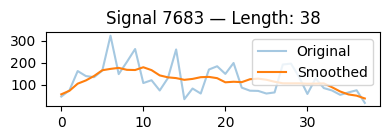

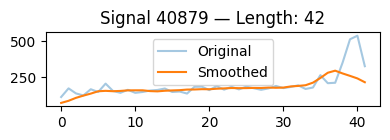

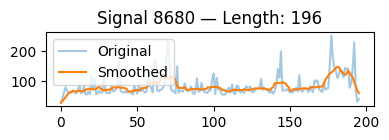

In [40]:
import random

indices = random.sample(range(len(signals)), 3)

# Plot original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  # faint
    plt.plot(smoothed, label='Smoothed')            # bold
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Savgol filter - fits polynomials to local windows of data

In [41]:
from scipy.signal import savgol_filter

smoothed_signals = [
    savgol_filter(row, window_length=16, polyorder=3)  
    for row in signals
]

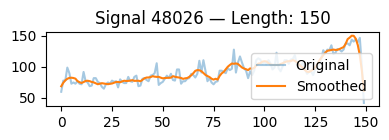

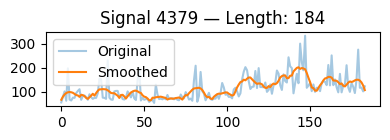

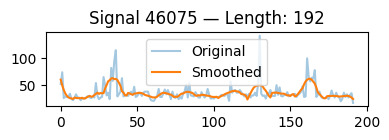

In [42]:
indices = random.sample(range(len(signals)), 3)

# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')           
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [43]:
from scipy.ndimage import gaussian_filter1d

smoothed_signals = [
    gaussian_filter1d(row, sigma=1.5)  
    for row in signals
]

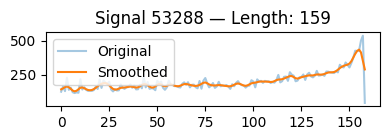

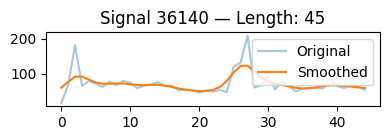

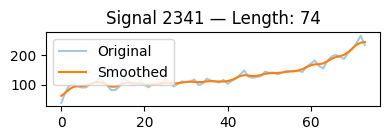

In [44]:
indices = random.sample(range(len(signals)), 3)

# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')           
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Median filter - replace values with median in the window

In [45]:
from scipy.signal import medfilt

smoothed_signals = [
    medfilt(row, kernel_size=3)  
    for row in signals
]

smoothed_signals = [
    savgol_filter(row, window_length=10, polyorder=3)  
    for row in smoothed_signals
]

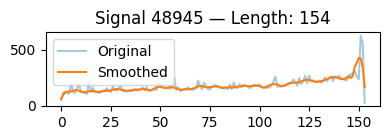

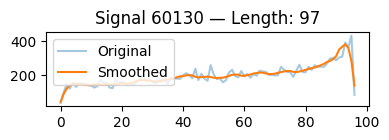

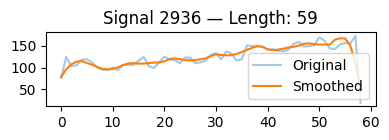

In [46]:
indices = random.sample(range(len(signals)), 3)

# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')           
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [47]:
from scipy.interpolate import interp1d

def resample_signal(signal, target_length):
    x_original = np.linspace(0, 1, len(signal))
    x_target = np.linspace(0, 1, target_length)
    interpolator = interp1d(x_original, signal, kind='cubic') 
    return interpolator(x_target)

target_length = 64

resampled_signals = [resample_signal(sig, target_length) for sig in signals]
resampled_smoothed = [resample_signal(sig, target_length) for sig in smoothed_signals]

In [299]:
indices = random.sample(range(len(signals)), 3)

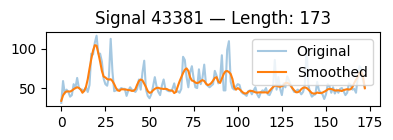

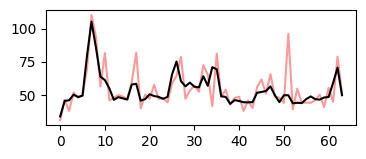

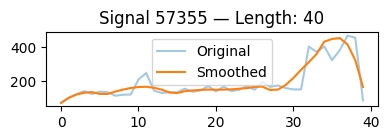

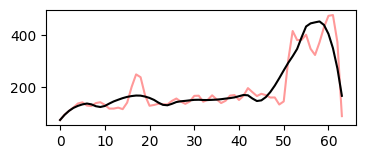

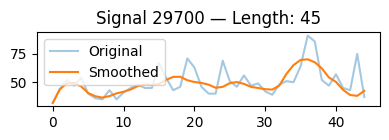

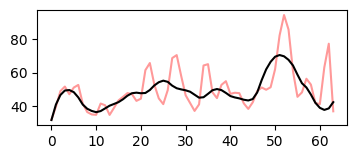

In [300]:
# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]
    rsignal = resampled_signals[idx]
    rsmoothed = resampled_smoothed[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')

    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4, 1.5))
    plt.plot(rsignal, c='red', alpha=0.4)
    plt.plot(rsmoothed, c='black')
    plt.show()   

Use these 64 length, smoothed functions (using Savgol Filter), test clustering, then label clusters manually, and use to classify events for signal events, background events (events with no protons/deuterons)

# Simple cut on ADC fluctuation
To cluster signal v. noise.

In [73]:
maxes = allclusters['column_maxes'].values

adcdiff = []

for i in maxes:
    cluster = []
    for j in range(len(i) - 1):
        entry = i[j+1] - i[j]
        cluster.append(entry)
    adcdiff.append(cluster)

In [144]:
maxes = allclusters['column_maxes'].values
adcdiff = [np.diff(signal) for signal in maxes]

In [97]:
bigdiff = [max(signal) for signal in adcdiff]

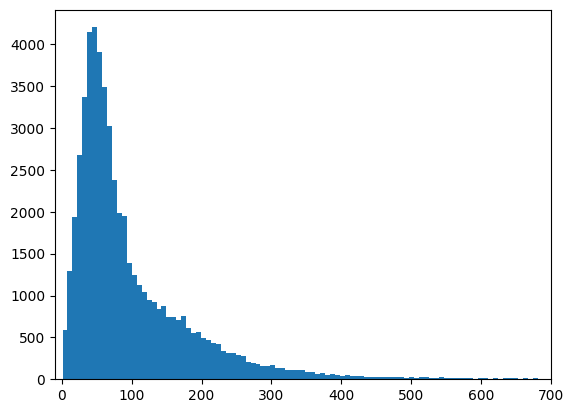

In [102]:
plt.figure()
plt.hist(bigdiff, bins=300)
plt.xlim(-10, 700)
plt.show()

Using normalised data. 

In [ ]:
# TODO: Is doing difference between i and i+1 best way to characterise sudden large ADC changes? 
# TODO: Plot clean full events + cluster identified. 
# TODO: Overlapping tracks that are clustered together, stay in the clean. 
        # Characterised by sudden change in the middle of the track (sudden drop in ADC) - this will need a seperate check.

In [560]:
maxes = allclusters['column_maxes'].values

nmaxes = []

for signal in maxes:
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val > min_val:
        normalized_signal = (signal - min_val) / (max_val - min_val)
    else:
        normalized_signal = np.zeros_like(signal, dtype=float)
        print('yo is there a problem?')
    nmaxes.append(normalized_signal)

nadcdiff = [np.diff(signal) for signal in nmaxes] # all changes + / -
nmaxdiff = [max(signal) for signal in nadcdiff]   # biggest positive change in ADC in each event

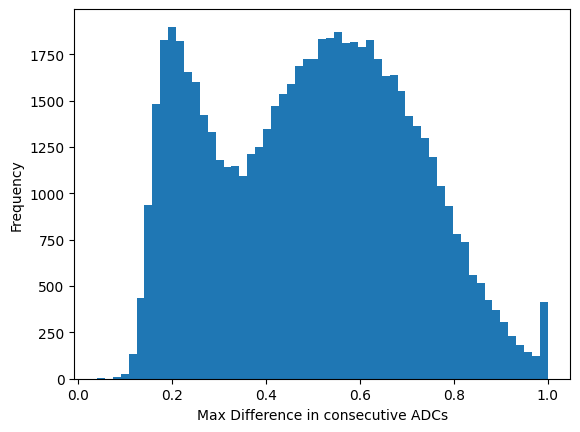

In [561]:
plt.figure()
plt.hist(nmaxdiff, bins='auto')
plt.xlabel('Max Difference in consecutive ADCs')
plt.ylabel('Frequency')
plt.show()

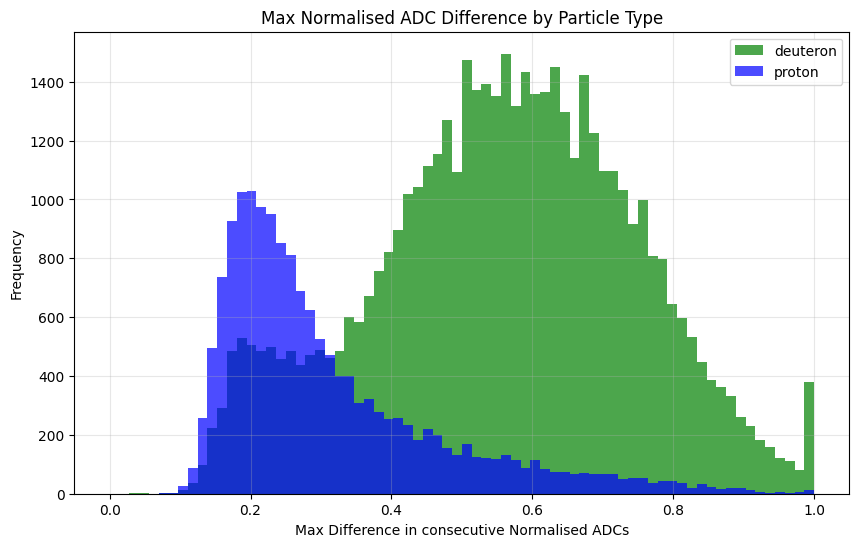

In [562]:
nmaxdiff = np.array(nmaxdiff)
particle_types = allclusters['particle_type'].values
unique_particles = allclusters['particle_type'].unique()

colors = {
    'proton': 'blue', 
    'deuteron': 'green'
}

plt.figure(figsize=(10, 6))

protons = []
deuterons = []

for p_type in unique_particles:
    mask = (particle_types == p_type)
    
    change = nmaxdiff[mask]

    if p_type == 'proton':
        protons = change
    else:
        deuterons = change


    plt.hist(change, 
             bins='auto',
             range=(0, 1), 
             alpha=0.7, 
             label=p_type, 
             color=colors.get(p_type, 'purple')) 

plt.title('Max Normalised ADC Difference by Particle Type')
plt.xlabel('Max Difference in consecutive Normalised ADCs')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [563]:
clean = np.where(nmaxdiff <= 0.26)[0]

Plotting 1 random 'clean' signals...


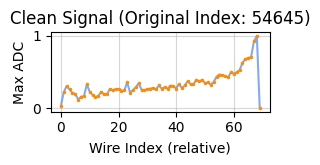

In [564]:
num_samples = 1

if len(clean) >= num_samples:
    sampled_indices = random.sample(list(clean), num_samples)

    print(f"Plotting {num_samples} random 'clean' signals...")
    for idx in sampled_indices:
        signal = nmaxes[idx]
        
        plt.figure(figsize=(3, 1.75))
        plt.plot(signal, color='cornflowerblue', alpha=0.8)
        plt.plot(signal, 'o', color='darkorange', markersize=1.5)
        plt.title(f"Clean Signal (Original Index: {idx})")
        plt.xlabel("Wire Index (relative)")
        plt.ylabel("Max ADC")
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()
else:
    print(f"Not enough clean signals to sample {num_samples}. Only {len(clean)} available.")

In [565]:
len(clean), clean

(11948, array([   46,    49,    56, ..., 64029, 64030, 64031]))

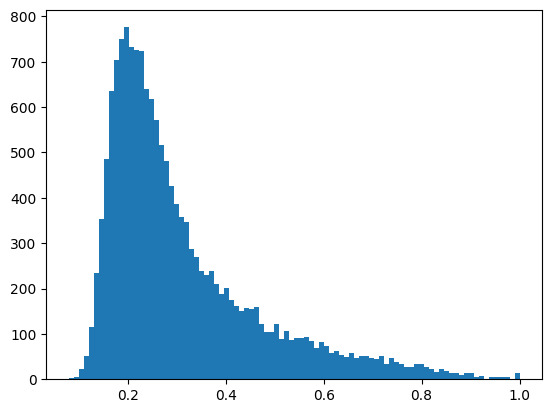

In [566]:
plt.hist(protons, bins=90)
plt.show()

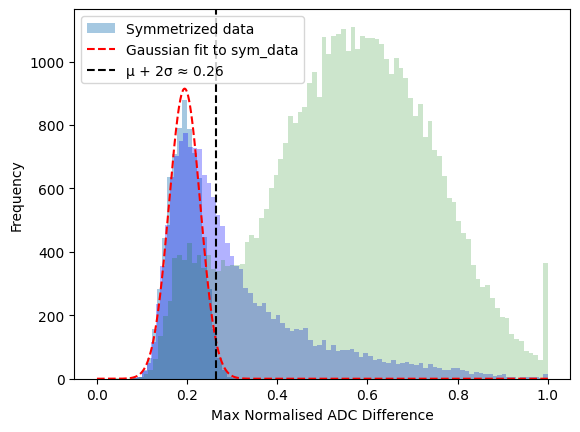

In [567]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

counts, bin_edges = np.histogram(protons, bins=90, range=(0, 1))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
peak_index = np.argmax(counts)
peak_x = bin_centers[peak_index]

left_half = protons[protons < peak_x]

mirrored = 2 * peak_x - left_half
sym_data = np.concatenate([left_half, mirrored])

mu_sym, sigma_sym = norm.fit(sym_data)

x = np.linspace(0, 1, 1000)
bin_width = (bin_edges[1] - bin_edges[0])
pdf_fit = norm.pdf(x, mu_sym, sigma_sym) * len(sym_data) * bin_width

# Plot
plt.hist(sym_data, bins=90, range=(0, 1), alpha=0.4, label='Symmetrized data')
plt.hist(protons, bins=90, color='blue', alpha=0.3)
plt.hist(deuterons, bins=90, color='green', alpha=0.2)
plt.plot(x, pdf_fit, 'r--', label='Gaussian fit to sym_data')
plt.axvline(mu_sym + 2 * sigma_sym, color='black', linestyle='--', label=f'μ + 2σ ≈ {mu_sym + 2*sigma_sym:.2f}')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Clean deuterons

In [585]:
deuteronmaxes = deuteronsdf['column_maxes'].values

deuteronnmaxes = []

for signal in deuteronmaxes:
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val > min_val:
        normalized_signal = (signal - min_val) / (max_val - min_val)
    else:
        normalized_signal = np.zeros_like(signal, dtype=float)
        print('yo is there a problem?')
    deuteronnmaxes.append(normalized_signal)

deuteronnadcdiff = [np.diff(signal) for signal in deuteronnmaxes] # all changes + / -
deuteronnmaxdiff = [max(signal) for signal in deuteronnadcdiff]   # biggest positive change in ADC in each event

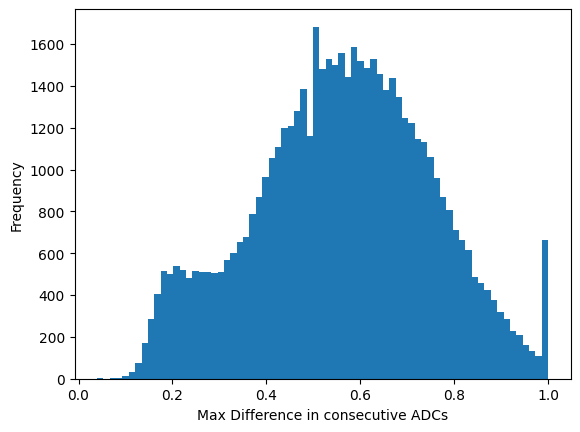

In [586]:
plt.figure()
plt.hist(deuteronnmaxdiff, bins='auto')
plt.xlabel('Max Difference in consecutive ADCs')
plt.ylabel('Frequency')
plt.show()

In [587]:
deuteronnmaxdiff = np.array(deuteronnmaxdiff)
deuteronclean = np.where(deuteronnmaxdiff <= 0.26)[0]

Plotting 1 random 'clean' signals...


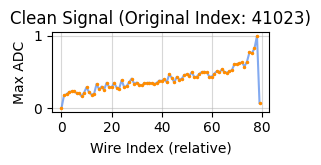

In [649]:
num_samples = 1

if len(deuteronclean) >= num_samples:

    sampled_indices = random.sample(list(deuteronclean), num_samples)

    print(f"Plotting {num_samples} random 'clean' signals...")
    for idx in sampled_indices:
        signal = deuteronnmaxes[idx]
        
        plt.figure(figsize=(3, 1.75))
        plt.plot(signal, color='cornflowerblue', alpha=0.8)
        plt.plot(signal, 'o', color='darkorange', markersize=1.5)
        plt.title(f"Clean Signal (Original Index: {idx})")
        plt.xlabel("Wire Index (relative)")
        plt.ylabel("Max ADC")
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()
else:
    print(f"Not enough clean signals to sample {num_samples}. Only {len(deuteronclean)} available.")

In [650]:
cleandeuteronsdf = deuteronsdf.iloc[clean]

In [651]:
collection_plane_df = cleandeuteronsdf[cleandeuteronsdf['plane'] == 'collection']
induction_plane_df = cleandeuteronsdf[cleandeuteronsdf['plane'] == 'induction']
collection_plane_df

,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness,image_intensity,matrix_transformed,column_maxes
37,6,9566,93,8335,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,1011.0,...,1141,37,1276,135,15,9.000000,0.499259,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0....","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0....","[70.0, 131.0, 196.0, 227.0, 274.0, 261.0, 258...."
60,10,9541,52,3741,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,4,2442.0,...,840,66,1189,349,36,9.694444,0.194365,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[18.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0...","[148.0, 225.0, 229.0, 227.0, 186.0, 240.0, 231..."
70,11,8744,154,15031,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,7237.0,...,573,142,1051,478,113,4.230088,0.133984,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, ...","[52.0, 122.0, 148.0, 152.0, 194.0, 148.0, 174...."
85,15,8613,70,5203,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,3,4259.0,...,899,89,1120,221,68,3.250000,0.283404,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[17.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[106.0, 140.0, 150.0, 170.0, 145.0, 132.0, 194..."
109,17,8563,69,3597,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,7224.0,...,924,146,1355,431,116,3.715517,0.144492,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[16.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0...","[47.0, 120.0, 128.0, 143.0, 140.0, 147.0, 134...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54690,6940,9486,57,4718,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,2,3168.0,...,1291,80,1535,244,51,4.784314,0.254581,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0....","[20.0, 112.0, 159.0, 147.0, 138.0, 158.0, 157...."
54704,6943,9489,116,8004,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,9,8331.0,...,616,173,986,370,141,2.624113,0.159689,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[27.0, 110.0, 174.0, 134.0, 124.0, 149.0, 125...."
54718,6946,9493,115,8574,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,3,808.0,...,975,43,1107,132,11,12.000000,0.556474,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[16.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, ...","[98.0, 214.0, 307.0, 345.0, 383.0, 360.0, 391...."
54788,6955,8611,49,3372,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,7742.0,...,750,154,1159,409,122,3.352459,0.155157,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0...","[[16.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, ...","[32.0, 81.0, 123.0, 154.0, 127.0, 137.0, 129.0..."


In [652]:
id = cleandeuteronsdf[['run', 'subrun', 'event']]
id = id.drop_duplicates().reset_index(drop=True)
id

,run,subrun,event
0,9566,93,8335
1,9541,52,3741
2,8744,154,15031
3,8648,80,6615
4,8613,70,5203
...,...,...,...
2823,9493,115,8574
2824,9508,144,14602
2825,8667,276,21860
2826,8611,49,3372
